In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import *

In [2]:
!sed -i 's/\r$//' /opt/hadoop/etc/hadoop/hadoop-env.sh

In [3]:
!hdfs dfsadmin -safemode leave

Safe mode is OFF


In [4]:
!hdfs dfs -rm -r /ml-latest-small
!hdfs dfs -put ml-latest-small /

rm: `/ml-latest-small': No such file or directory


In [5]:
conf = SparkConf().set("spark.executor.instances", "2").set("spark.executor.cores", "1").set("spark.executor.memory", "1g")

In [6]:
spark = SparkSession.builder.config(conf=conf).master(master="yarn").appName("pimenov_spark").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/29 01:46:11 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [7]:
spark

In [8]:
ratings_schema = StructType([StructField("userId", IntegerType()),
                             StructField("movieId", IntegerType()),
                             StructField("rating", DoubleType()),
                             StructField("timestamp", IntegerType())
])

df_ratings = spark.read.format('csv').option('header', 'True').schema(ratings_schema).load("/ml-latest-small/ratings.csv")

In [9]:
%%time
df_ratings.count()

CPU times: user 21.8 ms, sys: 4.98 ms, total: 26.8 ms
Wall time: 18.5 s


100836

In [10]:
tags_schema = StructType([StructField("userId", IntegerType()),
                             StructField("movieId", IntegerType()),
                             StructField("tag", StringType()),
                             StructField("timestamp", IntegerType())
])

df_tags = spark.read.format('csv').option('header', 'True').schema(tags_schema).load("/ml-latest-small/tags.csv")

In [11]:
%%time
df_tags.count()

CPU times: user 16.7 ms, sys: 2.66 ms, total: 19.4 ms
Wall time: 5.03 s


3683

Выполнено две таски, видно на скрине spark_jobs

In [12]:
df_ratings.select('userId').distinct().count()

610

In [13]:
df_ratings.filter(df_ratings.rating >= 4.0).count()

48580

In [14]:
df_ratings.sort(df_ratings.rating.desc()).show(100)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|   1617|   5.0|964982951|
|     1|   1625|   5.0|964983504|
|     1|     47|   5.0|964983815|
|     1|   1732|   5.0|964981125|
|     1|    101|   5.0|964980868|
|     1|   1804|   5.0|964983034|
|     1|    157|   5.0|964984100|
|     1|   1927|   5.0|964981497|
|     1|    216|   5.0|964981208|
|     1|   1954|   5.0|964982176|
|     1|    260|   5.0|964981680|
|     1|   2005|   5.0|964981710|
|     1|    362|   5.0|964982588|
|     1|   2018|   5.0|964980523|
|     1|    527|   5.0|964984002|
|     1|   2033|   5.0|964982903|
|     1|    596|   5.0|964982838|
|     1|   2048|   5.0|964982791|
|     1|    661|   5.0|964982838|
|     1|   2058|   5.0|964982400|
|     1|    923|   5.0|964981529|
|     1|   2078|   5.0|964982838|
|     1|    954|   5.0|964983219|
|     1|   2090|   5.0|964982838|
|     1|   1024|   5.0|964982876|
|     1|   2094|   5.0|964982653|
|     1|   102

In [15]:
df_joined = df_ratings.alias('rating').join(df_tags.alias('tag'), how='inner', on=['userId', 'movieId'])

In [16]:
df_diff = df_joined.withColumn("time_diff", (f.col('tag.timestamp') - f.col('rating.timestamp')))

In [17]:
df_diff.select(f.avg("time_diff") / 1e3).show()

+-------------------------+
|(avg(time_diff) / 1000.0)|
+-------------------------+
|       26243.727372266974|
+-------------------------+



In [18]:
df_ratings.groupBy('userId').agg(f.avg('rating')).agg(f.avg('avg(rating)')).show()

+------------------+
|  avg(avg(rating))|
+------------------+
|3.6572223377474016|
+------------------+



In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDRegressor

df_joined = df_joined.select('tag', 'rating')
df_pd = df_joined.toPandas().sample(frac=1).reset_index(drop=True)
df_pd.head()

,tag,rating
0,unoriginal,4.0
1,James Stewart,3.5
2,love,4.0
3,sweet,4.0
4,class,4.0


In [39]:
vectorizer = TfidfVectorizer()
tags_tfidf = vectorizer.fit_transform(df_pd.tag)
tags_tfidf.shape

(3476, 1708)

In [40]:
sgd_regr = SGDRegressor()
sgd_regr.fit(tags_tfidf, df_pd.rating)

SGDRegressor()

In [59]:
@f.udf(DoubleType())
def predict_ratings(tags):
    features = vectorizer.transform([tags])
    pred_ratings = sgd_regr.predict(features)
    return pred_ratings.item()

In [60]:
pred = predict_ratings(f.col('tag'))

In [61]:
df_res = df_joined.withColumn('pred_rating', pred)
df_res.show(50)

+--------------------+------+------------------+
|                 tag|rating|       pred_rating|
+--------------------+------+------------------+
|        will ferrell|   5.0| 4.026301094410628|
|     Highly quotable|   5.0|3.9515342448662363|
|               funny|   5.0| 4.368275578988325|
|           Tom Hardy|   5.0|3.8314398086898085|
|                 MMA|   5.0| 3.418009340123745|
|        Boxing story|   5.0| 3.930386449760093|
|     Martin Scorsese|   5.0|3.8496732685271455|
|   Leonardo DiCaprio|   5.0| 4.234972897492524|
|               drugs|   5.0| 4.287013800159387|
|        way too long|   1.0|3.4260018070404343|
|               mafia|   4.0|4.1551997530783735|
|            gangster|   4.0| 3.640420537843999|
|           Al Pacino|   4.0|3.8562201246647656|
|               Mafia|   5.0|4.1551997530783735|
|           Al Pacino|   5.0|3.8562201246647656|
|          true story|   4.5|   3.8547189332786|
|           holocaust|   4.5| 3.975288761151707|
|        twist endin

In [64]:
%%time
df_res.select(f.sqrt(f.avg(f.pow(f.col('rating') - f.col('pred_rating'), 2))).alias('rmse')).show()

+------------------+
|              rmse|
+------------------+
|0.8743253030115099|
+------------------+

CPU times: user 1.44 ms, sys: 18 ms, total: 19.4 ms
Wall time: 7.87 s


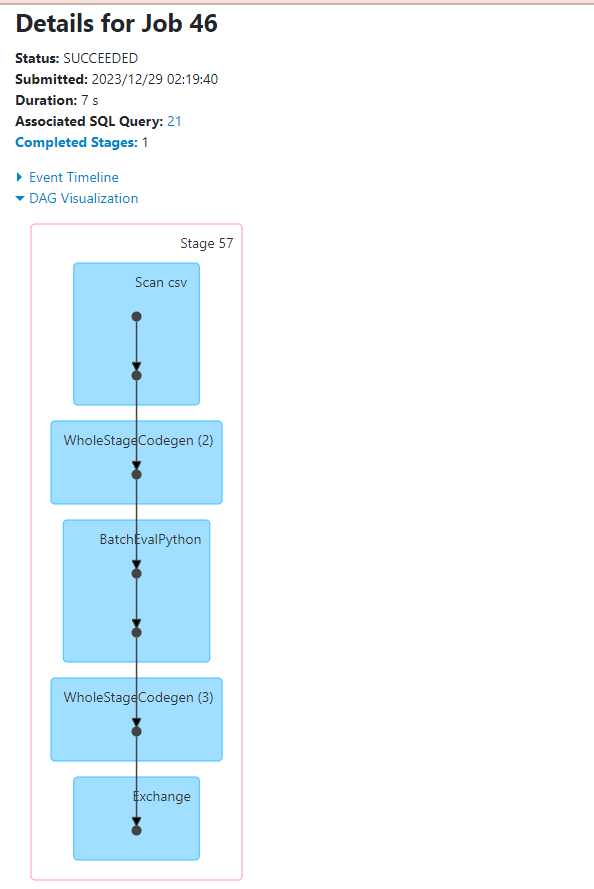
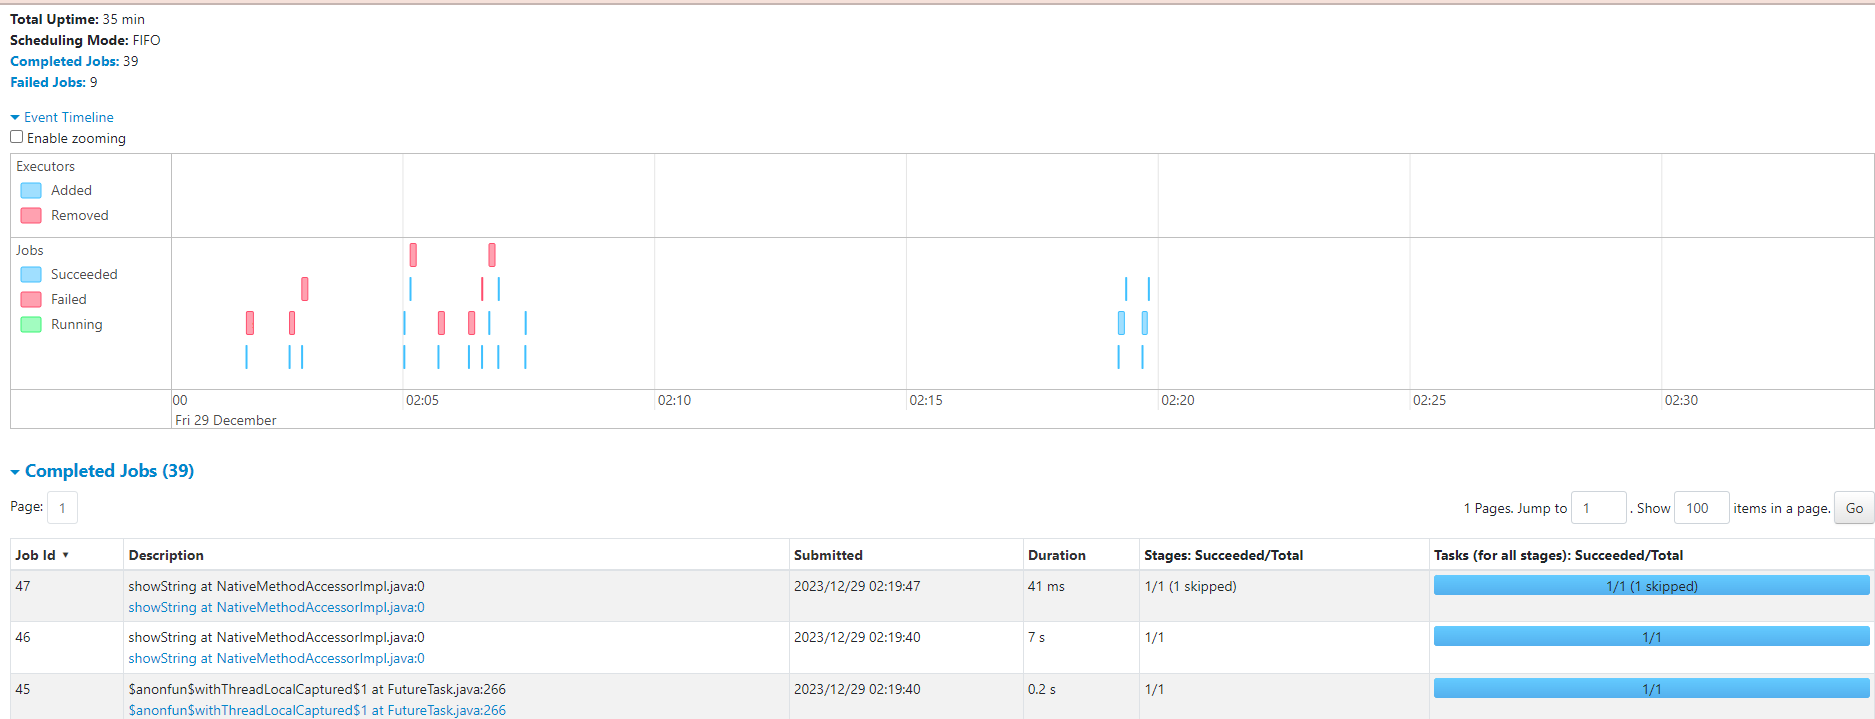
